## Loading packages and setting up Jupyter notebook

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline 
import seaborn as sns

import pdb 
import missingno  # for visualizing missing data

In [3]:
# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set seaborn options
sns.set()
sns.set_context("notebook") 

In [4]:
#mpl.rcParams['figure.figsize'] = (10.0, 10.0) 

## Inspecting data files

The data come in separate csv files that contain from a quarter up to multiple years of records. Let's inspect the individual files in the shell before importing them into pandas. 

In [5]:
!head -2 data_raw/*.csv

==> data_raw/LoanStats3a_securev1.csv <==
Notes offered by Prospectus (https://www.lendingclub.com/info/prospectus.action)
"id","member_id","loan_amnt","funded_amnt","funded_amnt_inv","term","int_rate","installment","grade","sub_grade","emp_title","emp_length","home_ownership","annual_inc","verification_status","issue_d","loan_status","pymnt_plan","url","desc","purpose","title","zip_code","addr_state","dti","delinq_2yrs","earliest_cr_line","fico_range_low","fico_range_high","inq_last_6mths","mths_since_last_delinq","mths_since_last_record","open_acc","pub_rec","revol_bal","revol_util","total_acc","initial_list_status","out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries","collection_recovery_fee","last_pymnt_d","last_pymnt_amnt","next_pymnt_d","last_credit_pull_d","last_fico_range_high","last_fico_range_low","collections_12_mths_ex_med","mths_since_last_major_derog","policy_code","application_type","annual_inc_jo

This reveals that the first line contains comments and should thus be discarded when importing the data. The column names start in the second line.

# Importing data

In [6]:
files = !ls data_raw/*.csv
df_list = []
for file in files:
    df_list.append(pd.read_csv(file, header=1, low_memory=False))

all_data = pd.concat(df_list)  

# Exploratory Data Analysis
Let's start with the dimension of our data set.

In [7]:
all_data.shape

(1873317, 151)

This reveals that we have about 1.8 million observations and 151 columns. Thus, let's start by getting rid of irrelevant observations and columns. We will then take a look at missing values in order to decide whether to impute them or to drop the whole column. 

Subsequently, we will explore how important loan outcomes have changed over time, and if we should discard data from the earliest years if it is too different from later observations. Once this is completed, we have arrived at the final set of observations and variables for the analysis, and we can start to explore distributions of individual variables as well as continue to explore relationship amongst other other variables.

## Dropping irrelevant observations
To zoom in on only the relevant observation, let us take a look at the variable of interest, loan_status. This will allow us to filter out cases where the outcome is ambiguous:

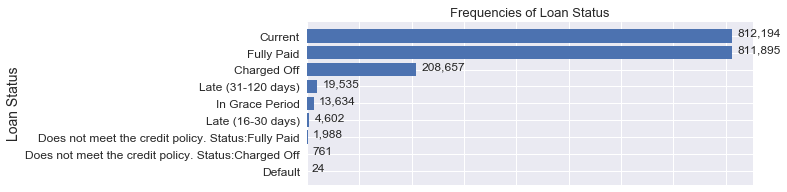

In [8]:
# sns.reset_defaults()

counts = all_data.loan_status.value_counts(ascending=True)  
ind = np.arange(len(counts))  # y-axis

fig, ax = plt.subplots(figsize=(8, 3))
ax.barh(y=ind, width=counts)

ax.set_title("Frequencies of Loan Status", fontsize=13)
# ax.set_xlabel("Frequencies of Loan Status", fontsize=14)
ax.set_ylabel("Loan Status", fontsize=14)
ax.set_yticks(ind)  # Get rid of extra ticks on top and bottom
ax.set_yticklabels(counts.index)

ax.grid(axis = 'x', color ='white', linestyle='-')
sns.despine(bottom=True)
ax.tick_params(axis='both', which='both',length=0, labelsize=12, labelbottom=False)
# ax.tick_params(axis='bottom', labelsize = 0)
for y_position, count in zip(ind, counts):  # Add frequencies
    plt.annotate(format(count, ','), xy=(count+10000, y_position))

plt.show()

As the above figure shows, the vast majority of loans fall into 3 classes: Loans that are still current, Loans that were paid back completely, and loans that were written-off (i.e., loans are unlikely to be paid back). Only a small fraction of loans (in fact, only 24, too small to be visible in the graph) are categorized as defaults (meaning that we can be certain that they won't be paid back). Furthermore, there is a small number of loans for which the status variable contains the string "does not meet the credit policy" in addition to whether it is fully paid or charged-off. Unfortunately, there is no explanation anywhere what exactly this means. I will simply treat them as fully paid or charged off, and ignore the information about not meeting the credit policy, which seems to be a separate variable. However, I do not use it for prediction, because it is likely that this information only became available after the loan was issued (since presumably the loan would not have been issued if it had been known at the time that the borrower did not meet the credit policy).    

The main question we need to decide is what exactly we want to predict.  I opt for a dichotomous classification into "fully paid" versus "charged off" and "default". For simplicity sake, I will call those "good" loans and "bad" loans. Note that those two classes are imbalanced.

Loans which are late – from still being in the grace period to up to 120 days late – will be discarded, because their status is yet indeterminate.  We have enough observations already, and thus any gain in accuracy from these additional observations would most likely be more than offset by the increase in variance due to the greater measurement error, because we do not have enough information yet to accurately classify them.

For similar reasons, I will discard loans that are still current.

In [9]:
# Create target variable (good or bad loans)
all_data['good'] = np.NaN
all_data.loc[all_data.loan_status.str.contains('Fully Paid', na=False), 'good'] = 1  # "Good" loans
all_data.loc[(all_data.loan_status.str.contains('Charged Off', na=False)|(all_data.loan_status=='Default')), 'good'] = 0  # "Bad"

In [10]:
# Drop loans with indeterminate status
all_data = all_data.loc[all_data.good.notnull(),:]

## Indexing and Sorting Data
A natural index for the data is the "id" column. But first we need to make sure that it doesn't have any missing values.

In [11]:
all_data.id.isnull().sum()

0

It doesn't have any missing values, so we can use it. However, it would also be good to additionally index the data by time, so that we can sort and later potentially slice them by time. (Amongst other, this will come in handy later when looking at missing values, because we want to know if certain variables were simply not collected for certain time periods, or if they are missing for other reasons.)

The data dictionary lists several candidates for the time index (from the time the borrower applied to the time they accepted the offer), but unfortunately none of these variables are actually contained in the data. Upon further inspection it becomes clear that most of the column names were changed and not updated in the data dictionary. Thus, let's take a look at all the column names and see if any sounds like they contain a relevant date:

In [12]:
list(all_data.columns)

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 '

The only potential date variable for the loan start date is "issue_d", presumably the issue date of the loan. Let's take a look how it's formatted, so we can more effectively parse it:

In [13]:
all_data.loc[:, 'issue_d'].head()

0    Dec-2011
1    Dec-2011
2    Dec-2011
3    Dec-2011
4    Dec-2011
Name: issue_d, dtype: object

Now we can set the issue date and loan ID as a hierarchical index, and then sort the data by date:

In [14]:
all_data = all_data.set_index([pd.to_datetime(all_data.loc[:,'issue_d'], format='%b-%Y'), 'id']).sort_index()

We will keep "issue_d" as a column (it will makes some things easier below), so we will rename it in the index to "issue_date".

In [15]:
all_data.shape

(1023325, 151)

In [25]:
all_data.index.names = ['issue_date', 'id']

## Dropping irrelevant columns

Now that we have discarded irrelevant rows, let's discard irrelevant columns. Since we are starting with about 150 columns, this will make the EDA easier.

### Dropping constant or all-missing columns
Let's start by deleting columns which are either constant or for which all observations are missing:

In [14]:
# Find columns with 0 or 1 unique values
constant_or_missing = [col for col in all_data.columns if all_data.loc[:,col].value_counts().shape[0]<=1] 
print(constant_or_missing)

# Delete those columns
all_data = all_data.drop(constant_or_missing, axis=1)

['member_id', 'pymnt_plan', 'policy_code', 'hardship_flag', 'hardship_type', 'deferral_term', 'hardship_length']


In [15]:
all_data.columns[all_data.columns.str.contains("list", case=False)]

Index(['initial_list_status'], dtype='object')

### Dropping endogenous columns
It is also important that we drop columns that contain information that was not available at the time the loan was issued (e.g., how much money the borrower has paid back so far). Needless to say, failing to do so could give us an unfair edge if we included any of these variables in our model. (In the language of statistics, they are endogenous to our model since they are a part of what we want to explain.)

Our first candidates for deletion are a number of date columns that I encountered when looking for the loan issue date. 

In [16]:
# Print further date columns
other_dates = all_data.columns[all_data.columns.str.contains("date", case=False)]
print(other_dates)

Index(['hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'debt_settlement_flag_date',
       'settlement_date'],
      dtype='object')


## Missing Values
Now that we have discarded irrelevant rows and columns, let us take a closer look at the data. Firstly, let's see what percentage of each column is missing.

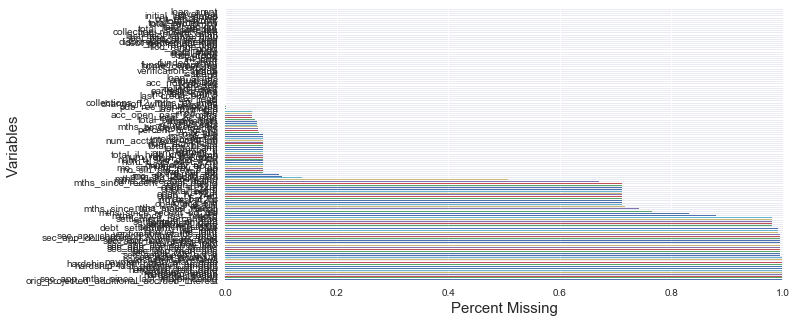

In [17]:
missing = (all_data.isnull().sum()/all_data.shape[0]).sort_values(ascending=False)
missing.plot(kind="barh", figsize=(10, 5))
plt.xlim(0, 1)
plt.xlabel('Percent Missing', fontsize=15)
plt.ylabel('Variables', fontsize=15)
plt.tick_params(labelsize=10, length=0)
plt.grid(color="white", axis='x')
# sns.despine()
plt.show()

Let us first focus on the big picture not worry about any individual variables. This reveals reveals an interesting pattern: About a third of the observations have no missing values, about a quarter of the variables has about 10% missing values, about 10% of the variables have around 70% missing values, and for about 1/3 of the variables almost all the data are missing.

The fact that there are no variables that have between 15% and 65% missing values makes it easier for us to decide at what proportion of missing values we should draw a cut-off between dropping a variable versus imputing missing values. I will choose 30% missing as the threshold, but any threshold between around 15% and around 65% would yield identical results.
    
Before we go ahead and drop any columns, let's make sure that values coded as missing are in fact missing rather than meaning "not applicable". To do that, we actually have to look at the meaning of each variable by hand. However, there is one shortcut we can use to eliminate some of that work: we can plot how missingness is related to the issue date. If this shows that missing mainly stems from the fact that the variable was not collected during a substantial part of our sample period, we know that we can safely discard it. Conversely, if missingness is seemingly randomly distributed over time, we need to take a closer look at the meaning of the variable notice before eliminating it.

Let's start by taking a look at how missingness is related to time for columns that have any missing values. (Note that we will not be able to identify the meaning of individual columns before zooming in on smaller subsets below.)

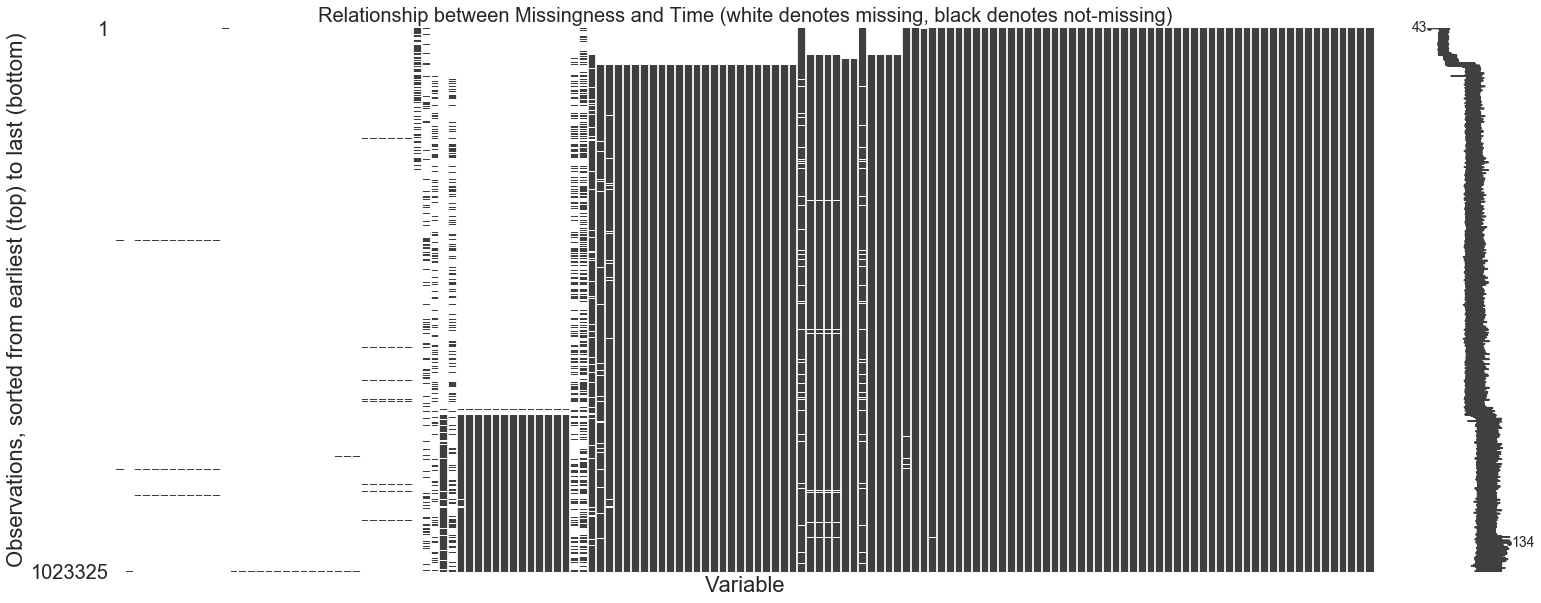

In [18]:
# Plot missing data
missingno.matrix(all_data.loc[:, missing.index])
plt.title('Relationship between Missingness and Time (white denotes missing, black denotes not-missing)', \
          fontsize=20)
plt.ylabel('Observations, sorted from earliest (top) to last (bottom)', fontsize=22)
plt.xlabel('Variable', fontsize=22)
plt.show();

This reveals that most of the missingness is caused by the fact that many variables were not collected over the whole sample period. On the very right, there is a line graph that is supposed to show the number of non-missing values for each observation (from 43 to 134), but due to look at the large number of observations graphed here, it is not very useful. To get a better sense of how the proportion of missingness of each variable changes over time, let's aggregate the observations by month and see how the proportion of missing values changed over time:

In [ ]:
# Group-by month and calculate percentage of missing values
percent_missing = all_data.groupby('issue_date').apply(lambda x: x.isnull().sum().sum()/(x.shape[0]*x.shape[1]))

# Plot
percent_missing.plot(ylim=(0, .7))

In [33]:
all_data.columns[all_data.columns.str.contains('issue')]

Index(['issue_d'], dtype='object')

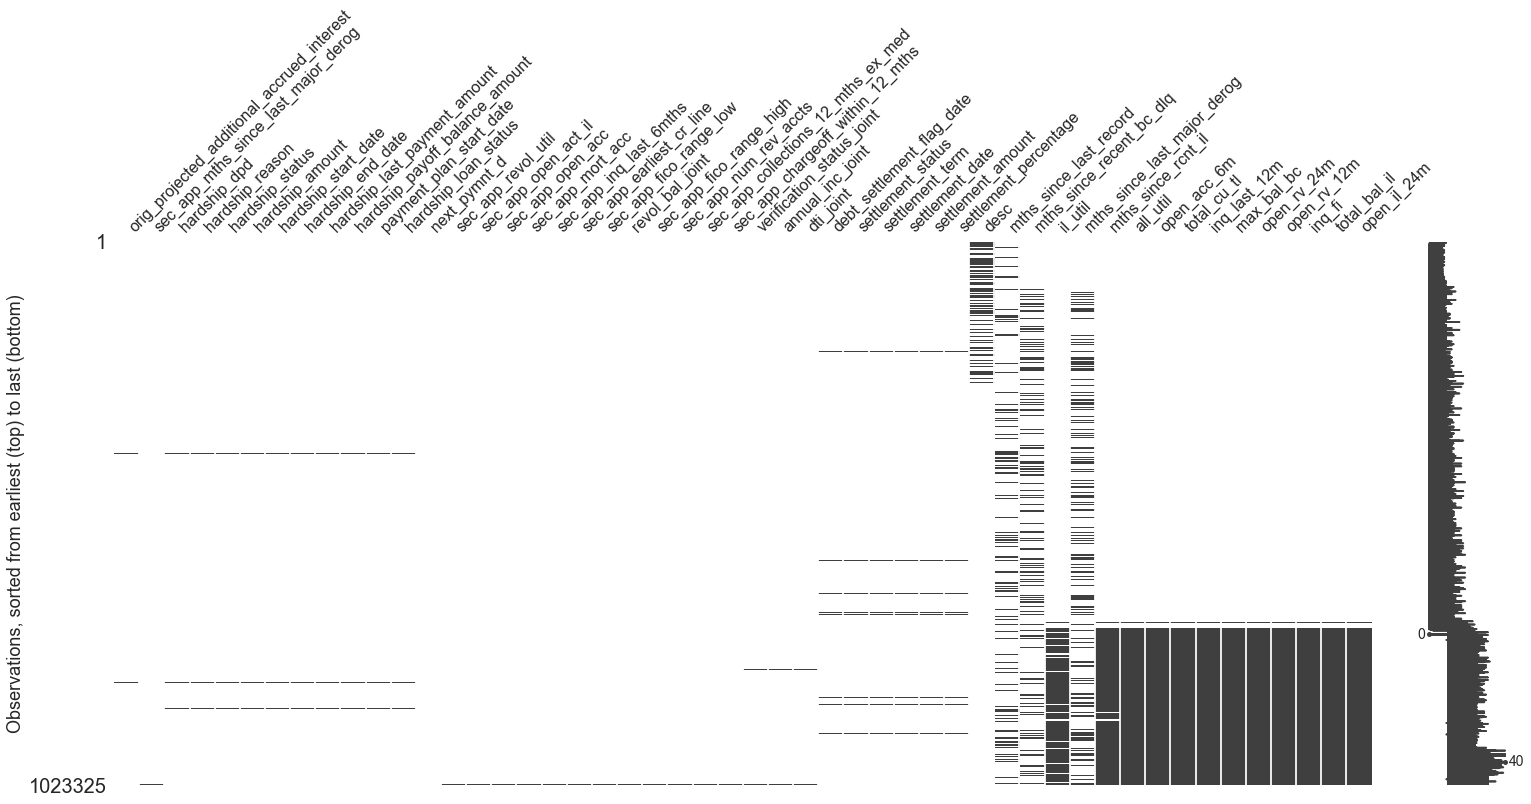

In [20]:
# Note that I don't exclude columns that have no missing values, because those will automatically be discarded as irrelevant by missingno.
#few_missing = missing.index[(missing>0) & (missing <.02)]
#many_missing = missing.index[missing >= .3]




# Plot missing data
missingno.matrix(all_data.loc[:, missing.index[:50]])
plt.ylabel('Observations, sorted from earliest (top) to last (bottom)', fontsize = 18)
plt.show();

(More detailed analysis and labeling of axes to follow.)

Before actually dropping any columns, let us first inspect which columns will get dropped:

In [21]:
# Select columns that will be dropped since they have more than 30% missing values
drop_95 = [col for col in missing.index[missing>.95]]  
drop_30_95 = [col for col in missing.index[(missing>.3)&(missing<=.95)]] 
print("Number of observations with over 95% missing values: {}".format(len(drop_95)))
print("Number of observations with between 30% and 95% missing values: {}\n".format(len(drop_30_95)))

# Print candidate columns for deletion
print(missing[missing>.3])

Number of observations with over 95% missing values: 34
Number of observations with between 30% and 95% missing values: 20

orig_projected_additional_accrued_interest    0.998637
sec_app_mths_since_last_major_derog           0.998283
hardship_dpd                                  0.997465
hardship_reason                               0.997465
hardship_status                               0.997465
hardship_amount                               0.997465
hardship_start_date                           0.997465
hardship_end_date                             0.997465
hardship_last_payment_amount                  0.997465
hardship_payoff_balance_amount                0.997465
payment_plan_start_date                       0.997465
hardship_loan_status                          0.997465
next_pymnt_d                                  0.997290
sec_app_revol_util                            0.995229
sec_app_open_act_il                           0.995147
sec_app_open_acc                              0.995

In [22]:
# Select columns that will be dropped since they have more than 30% missing values
drop = [col for col in missing.index[missing>.3]]  

# Divide those columns into categorical and continuous to plot them separately
# (Arbitrary cutoff for continuous: greater than 10 unique values)
drop_continuous = [col for col in drop if len(all_data[col].unique())>=10] 
drop_cat = [col for col in drop if col not in drop_continuous]

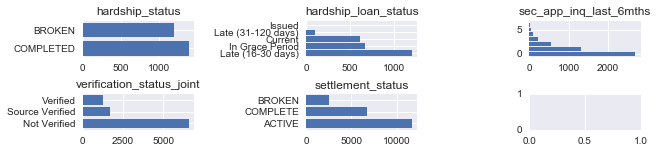

In [23]:
# Plot categorical variables to be dropped
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,2))
for subplot, col in zip(ax.ravel(), drop_cat):
    counts = all_data.loc[:,col].value_counts()
    subplot.barh(y=counts.index, width=counts)
    subplot.set_title(col)
fig.subplots_adjust(wspace=1, hspace=1)
plt.show()

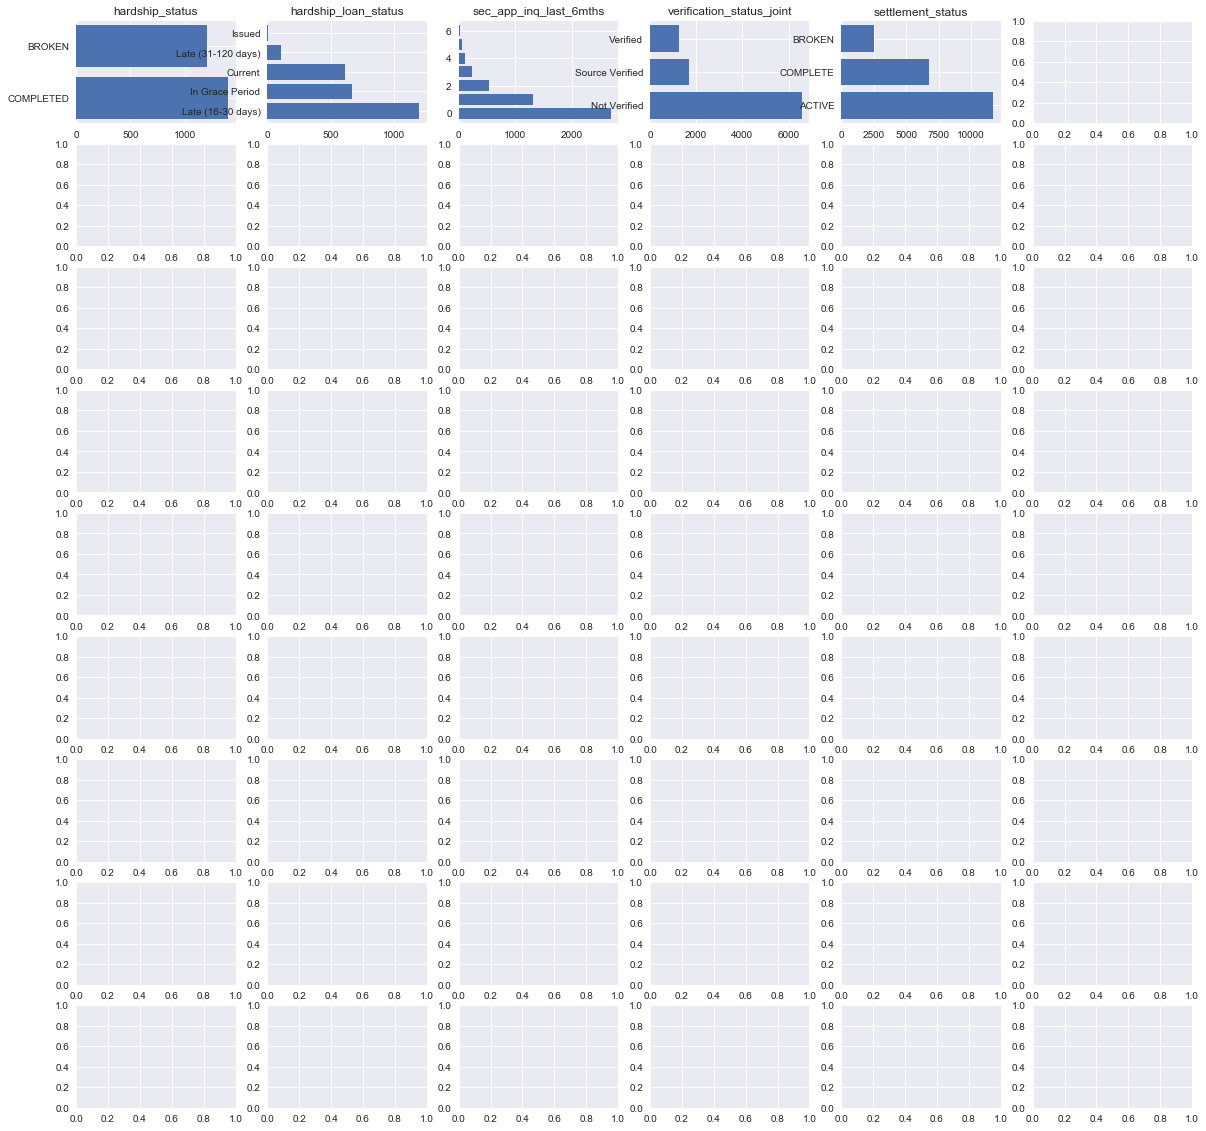

In [24]:

fig, ax = plt.subplots(nrows=9, ncols=6, figsize=(20, 20))
for subplot, col in zip(ax.ravel()[:6], drop_cat):
    counts = all_data.loc[:,col].value_counts()
    subplot.barh(y=counts.index, width=counts)
    subplot.set_title(col)
plt.show()

In [25]:
ax.ravel()[:6]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000016487E357F0>,
      dtype=object)

In [26]:
print(drop_continuous, drop_cat)

['orig_projected_additional_accrued_interest', 'sec_app_mths_since_last_major_derog', 'hardship_dpd', 'hardship_reason', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_payoff_balance_amount', 'payment_plan_start_date', 'next_pymnt_d', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_open_acc', 'sec_app_mort_acc', 'sec_app_earliest_cr_line', 'sec_app_fico_range_low', 'revol_bal_joint', 'sec_app_fico_range_high', 'sec_app_num_rev_accts', 'sec_app_collections_12_mths_ex_med', 'sec_app_chargeoff_within_12_mths', 'annual_inc_joint', 'dti_joint', 'debt_settlement_flag_date', 'settlement_term', 'settlement_date', 'settlement_amount', 'settlement_percentage', 'desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'il_util', 'mths_since_last_major_derog', 'mths_since_rcnt_il', 'all_util', 'open_acc_6m', 'total_cu_tl', 'inq_last_12m', 'max_bal_bc', 'open_rv_24m', 'open_rv_12m', 'inq_fi', 'total_bal_il', 'open_il_24m', 'open_il

In [27]:
assert(len(drop) == len(drop_continuous) + len(drop_cat))